# Case 4: OCR of D4BL COVID-19 Data with Selenium 

Author: Sydeaka Watson in support for Data 4 Black Lives effort to monitor racial/ethnic disparities in COVID-19 cases and deaths

In this notebook, we use Optical Character Recognition (OCR) to read race/ethnicity data from COVID-19 dashboards. Selenium will be used to automatically visit the link (using a Google Chrome web browser), take a screenshot, and crop the image to capture the race/ethnicity table for OCR parsing.

Reference: https://stackabuse.com/pytesseract-simple-python-optical-character-recognition/

Step 1: Install tesseract-ocr
https://github.com/tesseract-ocr/tesseract/wiki#homebrew

For MAC OS, follow instructions to install homebrew at https://brew.sh
`brew install tesseract`


Step 2: Install a few additional packages
`pip install pytesseract`
`pip install Pillow` 

#  Notes about data

I started working on pulling data for Louisiana and New York State (the first 2 of this type).
In the HTML for the Louisiana website, I found a link to public tableau dashboard that zooms in on the table without any headers or footers.
http://public.tableau.com/views/COVID19demog/DataonCOVIN-19RelatedDeathsToDate?:embed=y&:showVizHome=no&:host_url=https%3A%2F%2Fpublic.tableau.com%2F&:embed_code_version=3&:device=phone&:tabs=no&:toolbar=no&:showAppBanner=false&:loadOrderID=1

And the dashboard for NY State is here:
https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-Fatalities?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n

# Setup

### Set parameters

In [1]:
import os

DOCKER_PORT_CHROME = 32771
DOCKER_PORT_FIREFOX = 32661


PROJECT_ROOT = os.path.abspath('.')
home_dir = PROJECT_ROOT
#DRIVER_BIN = '/usr/local/bin/chromedriver' # Path to Google Chrome installation

### Load modules

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

from selenium import webdriver
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time



# Open CV
import cv2

import docker

### Load helper functions

#### Plotting utils

In [3]:
def display_image(image_path, fig_size=(20,10)):
    """
    This function will display image when provided a path to the image.
    """
    image = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(image)
    ax.axis('off')
    #plt.imshow(image)
    plt.show()

#### OCR

In [4]:
def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text


def proc_ocr_txt(txt_raw):
    """
    This function will split OCR text output on newlines ('\n') and remove blank lines.
    """
    txt = txt_raw.split('\n')
    txt_list = [x for x in txt if x.strip(' ') != '']
    return txt_list


In [5]:
def get_ocr_text(loc, target_url = None, port_number = None, 
                 screenshot_end_of_page = False, 
                 blur_type = 'bilateral', param_val = 75):
    
    print('\n\n\nScreenshot of {} dashboard'.format(loc))
    
    if loc == 'Louisiana-2':
        browser_type = 'firefox'
    else:
        browser_type = 'chrome'
    
    get_screenshot(loc, target_url = target_url, show_image=False, port_number=port_number, 
                            screenshot_end_of_page = screenshot_end_of_page, browser_type = browser_type)
    print('Crop image')
    get_crop(loc, show_image=True)
    png_path = png_cropped[loc]
    print('Image pre-processing for Tesseract')
    png_preprocessed = image_preprocessing(png_path, blur_type = blur_type, param_val = param_val)
        
    print('Get raw OCR output from tesseract')
    txt_raw = ocr_core(png_preprocessed);  print(txt_raw)
    print('Split OCR text output on newlines and remove blank lines.')
    txt = proc_ocr_txt(txt_raw);  # print(txt)
    return txt

In [6]:
def ocr_louisiana(loc='Louisiana', port_number = None, screenshot_end_of_page = False):
    txt = get_ocr_text(loc, target_url = dashboard_urls['Louisiana'][0],
                       port_number = port_number, screenshot_end_of_page = screenshot_end_of_page)
    names_la = txt[0:7] #;  print(names_la)
    vals_la = txt[7:] #; print(vals_la)
    dict_la = {names_la[i]: {'Pct Deaths': float(vals_la[i].replace('%', ''))} for i in range(len(names_la))}
    out = pd.DataFrame(dict_la).T
    #display(out)
    return(out)


def ocr_nystate(loc='New York State', port_number = None, screenshot_end_of_page = False):
    
    txt = get_ocr_text(loc, target_url = dashboard_urls['New York State'][0],
                           port_number = port_number, screenshot_end_of_page = screenshot_end_of_page,
                           blur_type = 'bilateral', param_val = 75)
        
    ## Getting the raw outputs for cell in the table
    ## This case will require a separate step to split the % deaths from the % population values
    names_nystate = ['Hispanic', 'Black', 'White', 'Asian', 'Other']
    vals_nystate = [x for x in txt if 'population' in x]; # print(vals_nystate)
    nyc = {names_nystate[i]: vals_nystate[i].replace('(', '').replace(' of population)', '') for i in range(len(names_nystate))}
    nys_excl_nyc = {names_nystate[i]: vals_nystate[len(names_nystate) + i].replace('(', '').replace(' of population)', '') for i in range(len(names_nystate))}
    ## New York City Only
    display(parse_nyc(nyc))
    ## New York State excluding New York City
    display(parse_nyc(nys_excl_nyc))
    return({'New York City Only': parse_nyc(nyc),
           'New York State excluding New York City': parse_nyc(nys_excl_nyc)})

## Helper function to split out % fatalities from % population for each racial/ethnic group
def parse_nyc(nyc_dict):
    pct_deaths = {key: {'Pct Deaths': nyc_dict[key].split(' ')[0].replace('%', '')} for key in nyc_dict.keys()}
    pct_pop = {key: {'Pct Popn': nyc_dict[key].split(' ')[1].replace('%', '')} for key in nyc_dict.keys()}
    nyc_output_df = pd.DataFrame(pct_deaths).T
    nyc_output_df['Pct Popn'] = pd.DataFrame(pct_pop).T['Pct Popn']
    
    return nyc_output_df


def ocr_louisiana2(loc='Louisiana-2', port_number = DOCKER_PORT_FIREFOX, screenshot_end_of_page = False):
    txt = get_ocr_text(loc, target_url = dashboard_urls['Louisiana-2'][0],
                       port_number = port_number, screenshot_end_of_page = screenshot_end_of_page)
    vals = [int(x.replace(',', '')) for x in txt[0].split()]
    out = {'cases': vals[0], 'deaths': vals[1]}
    return(out)


ocr_functions = {
    'Louisiana': ocr_louisiana,
    'Louisiana-2': ocr_louisiana2,
    'New York State': ocr_nystate
}

#### Docker utils

In [7]:
selenium_browser_images = {
    'firefox': 'selenium/standalone-firefox-debug',
    'chrome': 'selenium/standalone-chrome-debug'
    
}


def start_docker(port_number = None, VNC_PORT = None, browser_type = 'chrome'):
    browser_image = selenium_browser_images[browser_type]
    
    try:
        client = docker.from_env()
        client.containers.run(browser_image, 
                              detach = True,  publish_all_ports = True,
                              ports =  {'4444/tcp': port_number,  '5900/tcp': VNC_PORT} 
                             )

        print('IDs of running docker containers:')
        print(client.containers.list())
        return client
    except Exception as inst:
        print("Error starting docker container")
        print(inst)
        
        
    
def stop_docker(client):
    try:
        client.containers.list()[0].stop()
    except Exception as inst:
        print("Error stopping docker container")
        print(inst)



#### Browser utils

In [8]:
def get_browser(browser_type = 'chrome', port_number = None):
    docker_url = 'http://localhost:{}/wd/hub'.format(port_number)
    
    if browser_type == 'chrome':
        browser = webdriver.Remote(docker_url, DesiredCapabilities.CHROME)
    elif browser_type == 'firefox':
        browser = webdriver.Remote(docker_url, DesiredCapabilities.FIREFOX)
    else:
        print('Invalid browser_type')
        return None
    
    return browser
        

#### Screenshot and cropping

In [9]:
def get_screenshot(location_name, target_url = None, sleep_seconds=5, show_image = False, 
                   screenshot_end_of_page = False,
                   port_number=None,
                   browser_type = 'chrome'
                  ):
    #target_url = dashboard_urls[location_name] 
    output_filename = png_screenshots[location_name]

    browser = get_browser(browser_type = browser_type, port_number = port_number)
    
    browser.get(target_url)
    browser.set_window_position(x=0,y=50)
    browser.set_window_size(1024, 600)
    browser.maximize_window()
    time.sleep(sleep_seconds)
    png_filename = os.path.join(home_dir, 'screenshots', "{}.png".format(output_filename))
    browser.save_screenshot(png_filename)
    print('Screenshot saved to {}'.format(png_filename))
    
    if screenshot_end_of_page:
        print('Scroll down and take another screenshot')
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        png_filename = os.path.join(home_dir, 'screenshots', "{}_endofpage.png".format(output_filename))
        browser.save_screenshot(png_filename)
        print('Screenshot saved to {}'.format(png_filename))
    
    #time.sleep(10)
    browser.close()
    if show_image:
        display_image(png_filename)



def get_crop(location, show_image = False, image_file=None):
    if image_file is None:
        image_file = os.path.join(home_dir, 'screenshots', "{}.png".format(png_screenshots[location]))
    
    # Opens a image in RGB mode 
    im = Image.open(image_file) 
    
    # Size of the image in pixels (size of orginal image) 
    width, height = im.size 
    
    ## Get bounding box of area to crop
    crop_bbox = get_crop_boundary(location, width, height)
    
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((crop_bbox['left'], 
                   crop_bbox['top'], 
                   crop_bbox['right'], 
                   crop_bbox['bottom'])) 

    # Shows the image in image viewer 
    # out_file = os.path.join('screenshots', "cropped_{}.png".format(location))
    out_file = png_cropped[location]
    im1.save(out_file) 
    if show_image:
        display_image(out_file)
    

In [10]:
# gaussian, bilateral, average, median blurring



def blur(img, blur_type='gaussian', param_val = None):        
    if blur_type == 'gaussian':
        img = cv2.GaussianBlur(img, (param_val, param_val), 0)
    elif blur_type == 'bilateral':
        img = cv2.bilateralFilter(img,9,param_val,param_val)
    elif blur_type == 'average':
        img = cv2.blur(img,(param_val, param_val))
    elif blur_type == 'median':
        img = cv2.medianBlur(img, param_val)
    else:
        print('Invalid blur_type')
    
    return img



def image_preprocessing(img_file, blur_type = 'gaussian', param_val = None):
    # Output filename
    out_file = img_file.replace('.png', '_preproc.png')
    
    # Read the image in with cv2, in grayscale
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    display_image(img_file)
    
    # Enlarge image (make it 2x height and 2x width)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # Blurring to improve Tesseract performance
    img = blur(img, blur_type,  param_val)
    
    # Convert gray to RGB
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    # Save the output to a file
    cv2.imwrite(out_file,img)
    
    display_image(out_file)
    
    return out_file

In [11]:
def data_extract_louisiana(validation=False, home_dir=None):
    try:
        location_name = 'Louisiana'

        print('Navigate to Louisiana data folder')
        dir = os.path.join(home_dir, 'data', 'louisiana')
        os.chdir(dir)

        print('Get OCR output')
        
        ocr_output =  ocr_louisiana(loc='Louisiana', port_number = DOCKER_PORT_CHROME, screenshot_end_of_page = True)

        print('Get percent of AA deaths')
        la_aa_pct_deaths = ocr_output.loc['Black']['Pct Deaths']

        print('Get date from bottom of the page')
        la_bottom = os.path.join(home_dir, 'screenshots', 'screenshot_louisiana_endofpage.png')
        #display_image(la_bottom)
        txt_bottom_la = ocr_core(la_bottom).split('\n')
        o = [x for x in txt_bottom_la if 'Last updated' in x][0]
        la_date = o.split('Last updated ')[1].replace('.', '')
        
        print('Get counts of cases and deaths from main page')
        ocr_output =  ocr_louisiana2(loc='Louisiana-2', port_number = DOCKER_PORT_FIREFOX, screenshot_end_of_page = False)
        cases = ocr_output['cases']
        deaths = ocr_output['deaths']
        
        os.chdir(home_dir)

        return {
            'Location': location_name,
            'Date Published': la_date,
            'Total Cases': cases,
            'Total Deaths': deaths,
            'Count Cases Black/AA': np.nan,
            'Count Deaths Black/AA': np.nan,
            'Pct Cases Black/AA': np.nan,
            'Pct Deaths Black/AA': la_aa_pct_deaths,
            'Status code': success_code
            }
    except Exception as inst:
        print(inst)
        os.chdir(home_dir)
    
success_code = 'Success!'

In [12]:
def data_extract_nystate(validation=False, home_dir=None):
    location_name = 'New York State'
    
    print('Navigate to {} data folder'.format(location_name))
    dir = os.path.join(home_dir, 'data', 'ny_state')
    os.chdir(dir)
    
    print('Get OCR output')
    ocr_output = ocr_nystate(location_name, port_number = DOCKER_PORT_CHROME)
    
    print('Get percent of AA deaths')
    aa_pct_deaths = int(ocr_output['New York State excluding New York City'].loc['Black']['Pct Deaths'])
    
    print('Get OCR output for report date')
    ocr_output = get_ocr_text('New York State-2', 
             target_url = dashboard_urls['New York State'][0], port_number = DOCKER_PORT_CHROME)
    report_date = ocr_output[1].split(':')[1].strip()
    
    print('Get OCR output for total deaths')
    
    def nystate3(param_val):
        ocr_output = get_ocr_text('New York State-3', target_url = dashboard_urls['New York State'][0],
                           port_number = DOCKER_PORT_CHROME, 
                           blur_type = 'bilateral', param_val = param_val)
        vals = ocr_output[0].split('Grand Total ')[1]
        vals = vals.split(' ')[0]
        deaths = int(vals.replace(',', ''))
        return  ocr_output, vals, deaths
    
    

    try:
        print('OCR attempt #1.')
        ocr_output, vals, deaths  = nystate3(param_val=75)
        print('OCR success on attempt #1!')
    except Exception as inst:
        print(inst)
        try:
            print('OCR attempt #2.  Trying different preprocessing blur.')
            ocr_output, vals, deaths  = nystate3(param_val=22)
            print('OCR success on attempt #2!')
        except Exception as inst:
            print('OCR errors. Halting execution.')
            os.chdir(home_dir)
            return {
            'Location': location_name,
            'Date Published': np.nan,
            'Total Cases': np.nan,
            'Total Deaths': np.nan,
            'Count Cases Black/AA': np.nan,
            'Count Deaths Black/AA': np.nan,
            'Pct Cases Black/AA': np.nan,
            'Pct Deaths Black/AA': np.nan,
            'Status code': 'OCR error: failed to detect expected text format'
            }
        
    os.chdir(home_dir)
    
    return {
        'Location': location_name,
        'Date Published': report_date,
        'Total Cases': np.nan,
        'Total Deaths': deaths,
        'Count Cases Black/AA': np.nan,
        'Count Deaths Black/AA': np.nan,
        'Pct Cases Black/AA': np.nan,
        'Pct Deaths Black/AA': aa_pct_deaths,
        'Status code': success_code
        }
    
success_code = 'Success!'

In [13]:
#display_image(os.path.join(home_dir, 'screenshots', 'screenshot_ny.png'))

In [14]:
def get_crop_boundary(location, width, height):
    y = -80 # vertical offset for Louisiana
    crop_boundaries = {
        'Louisiana': {'left': 0, 'top': height * 0.18  + y, 'right': width/3, 'bottom': 0.45 * height+  y},
        'Louisiana-2': {'left': 0, 'top': height * 0.12, 'right': 2*width/3, 'bottom': 0.20 * height},
        'New York State': {'left': 0.47 * width, 'top': height * 0.17, 'right': width, 'bottom': 0.31 * height},
        'New York State-2': {'left': 0.80 * width, 'top': 0, 'right': width, 'bottom': 0.09 * height},
        'New York State-3': {'left': 0, 'top': 0.21 * height, 'right': 0.47 * width, 'bottom': 0.24 * height}
    }
    
    return crop_boundaries[location]

In [15]:
#filenm = os.path.join(home_dir, 'screenshots', 'screenshot_ny.png')
#get_crop(location='New York State-3', show_image = True, image_file=filenm)

In [16]:
os.listdir(os.path.join(home_dir, 'screenshots'))

['screenshot_ny.png',
 'cropped_New York State-2_preproc.png',
 'screenshot_louisiana-2.png',
 'cropped_Louisiana-2_preproc.png',
 'screenshot.png',
 'screenshot_louisiana.png',
 'firefox_louisiana_arcgis.png',
 'cropped_New York State-3_preproc.png',
 'cropped_Louisiana-2.png',
 'cropped_New York State-2.png',
 'cropped_Louisiana.png',
 'myfile.png',
 'cropped_New York State-3.png',
 'cropped_New York State_preproc.png',
 'cropped_New York State.png',
 'cropped_Louisiana_preproc.png',
 'screenshot_louisiana_endofpage.png']

In [17]:
#ocr_louisiana(loc='Louisiana', port_number = DOCKER_PORT, screenshot_end_of_page = True)
#ocr_nystate(loc='New York State', port_number = DOCKER_PORT, screenshot_end_of_page = False)

# Use Selenium to get screenshots

References: 
* https://stackoverflow.com/questions/39428042/use-selenium-with-chromedriver-on-mac
* https://pythonspot.com/selenium-take-screenshot/

### Start Docker

In [18]:
client_chrome = start_docker(port_number = DOCKER_PORT_CHROME, VNC_PORT = DOCKER_PORT_CHROME+1, browser_type = 'chrome')
client_firefox = start_docker(port_number = DOCKER_PORT_FIREFOX, VNC_PORT = DOCKER_PORT_FIREFOX+1, browser_type = 'firefox')

IDs of running docker containers:
[<Container: f48bffbefc>]
IDs of running docker containers:
[<Container: a359a43f64>, <Container: f48bffbefc>]


In [19]:
time.sleep(10)

In [20]:
#!docker ps

In [21]:
dashboard_urls = {
    'Louisiana': ["http://public.tableau.com/views/COVID19demog/DataonCOVIN-19RelatedDeathsToDate?:embed=y&:showVizHome=no&:host_url=https%3A%2F%2Fpublic.tableau.com%2F&:embed_code_version=3&:device=phone&:tabs=no&:toolbar=no&:showAppBanner=false&:loadOrderID=1",
                  ],
    'Louisiana-2': ["https://www.arcgis.com/apps/opsdashboard/index.html#/69b726e2b82e408f89c3a54f96e8f776"],
    'New York State': ["https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-Fatalities?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n"]
}

png_screenshots = {
    'Louisiana': 'screenshot_louisiana',
    'Louisiana-2': 'screenshot_louisiana-2',
    'New York State': 'screenshot_ny',
    'New York State-2': 'screenshot_ny',
    'New York State-3': 'screenshot_ny'
}

locations = list(png_screenshots.keys()); locations

png_cropped = {loc: os.path.join(home_dir, 'screenshots', "cropped_{}.png".format(loc)) for loc in locations}; png_cropped


{'Louisiana': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_Louisiana.png',
 'Louisiana-2': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_Louisiana-2.png',
 'New York State': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_New York State.png',
 'New York State-2': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_New York State-2.png',
 'New York State-3': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_New York State-3.png'}

# Data Extraction

In [22]:
output = dict()

Navigate to Louisiana data folder
Get OCR output



Screenshot of Louisiana dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_louisiana.png
Scroll down and take another screenshot
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_louisiana_endofpage.png
Crop image


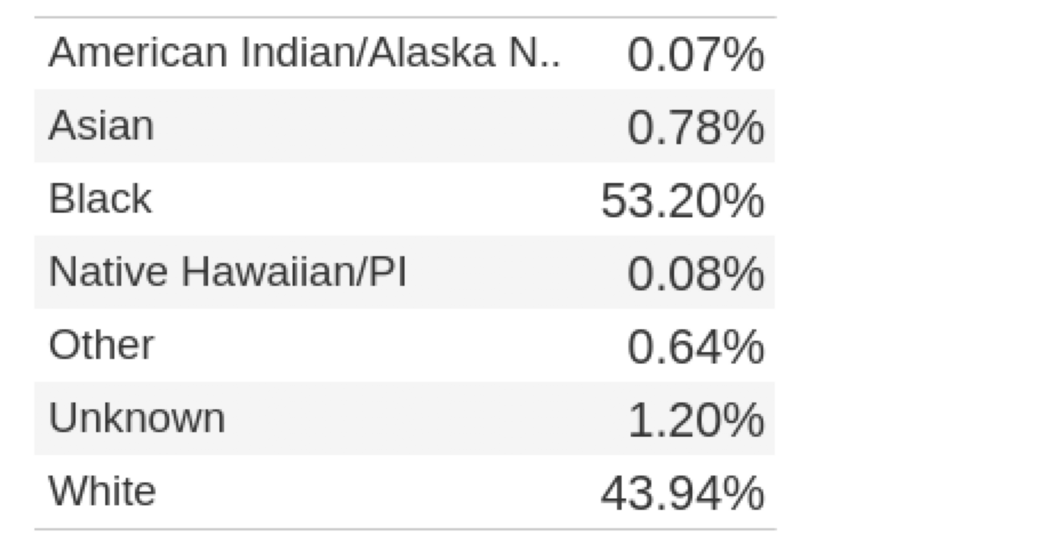

Image pre-processing for Tesseract


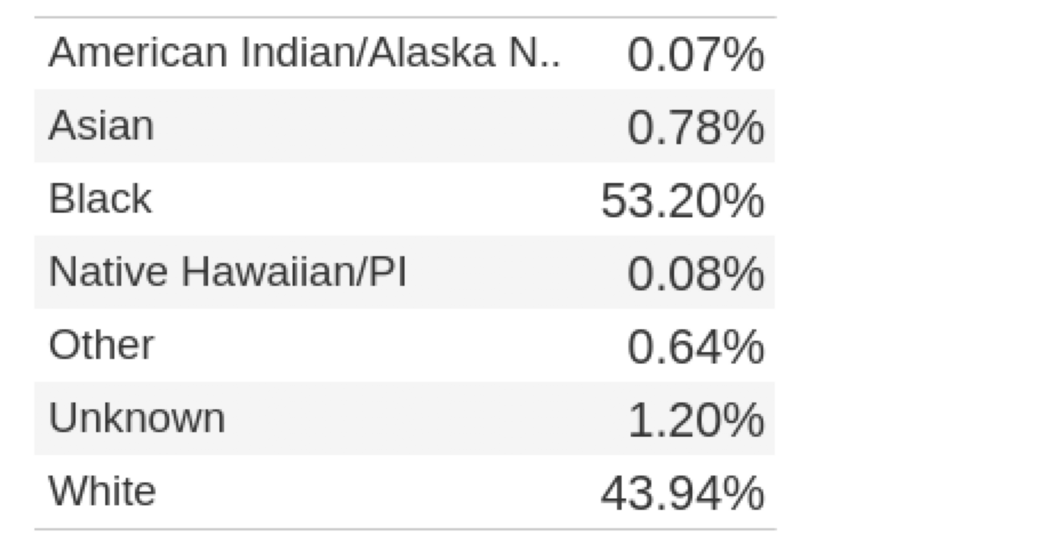

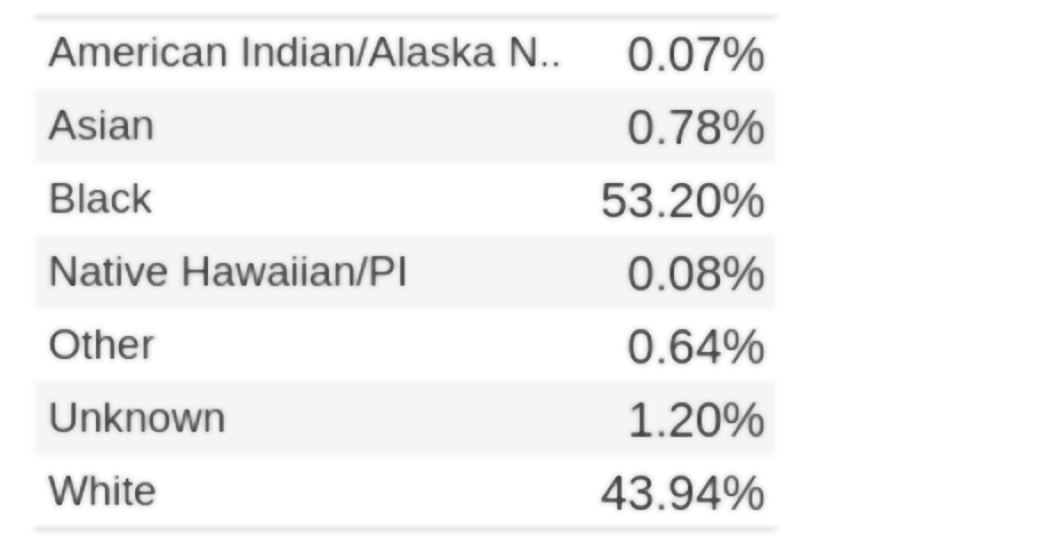

Get raw OCR output from tesseract
American Indian/Alaska N..

Asian

Black

Native Hawaiian/Pl
Other

Unknown

White

0.07%
0.78%
53.20%
0.08%
0.64%
1.20%
43.94%
Split OCR text output on newlines and remove blank lines.
Get percent of AA deaths
Get date from bottom of the page
Get counts of cases and deaths from main page



Screenshot of Louisiana-2 dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_louisiana-2.png
Crop image


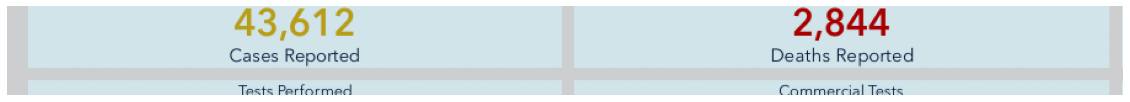

Image pre-processing for Tesseract


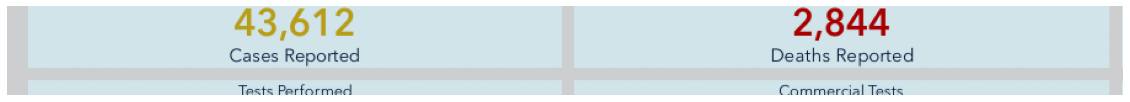

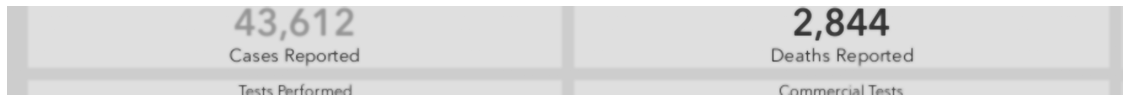

Get raw OCR output from tesseract
3,612 2,844

Cases Reported Deaths Reported

Taete Parcfarmad Commercial! Tect<
Split OCR text output on newlines and remove blank lines.


In [23]:
output['Louisiana'] = data_extract_louisiana(validation=False, home_dir=home_dir)

Navigate to New York State data folder
Get OCR output



Screenshot of New York State dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_ny.png
Crop image


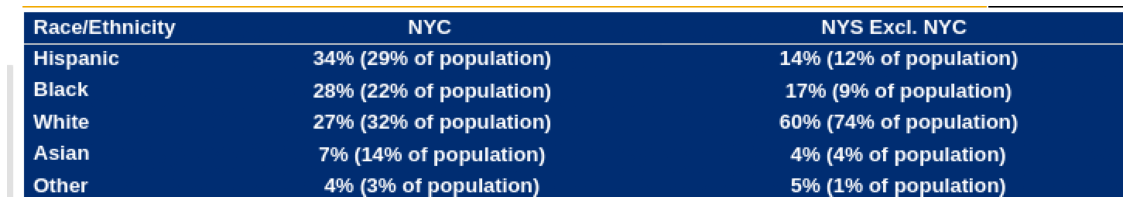

Image pre-processing for Tesseract


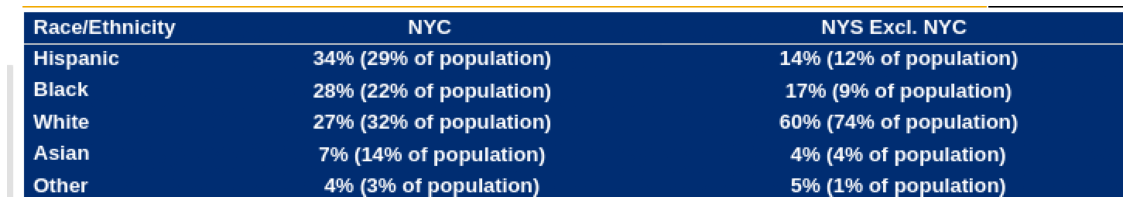

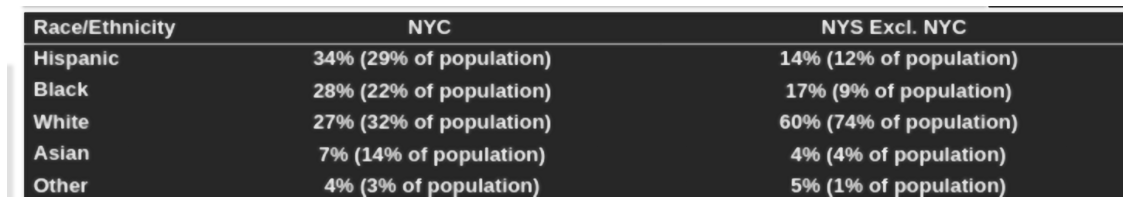

Get raw OCR output from tesseract
Race/Ethnicity

NYC

 

NYS Excl. NYC

 

Hispanic
Black
Sa
Asian
Other

34% (29% of population)
28% (22% of population)
27% (32% of population)
7% (14% of population)
4% (3% of population)

14% (12% of population)
17% (9% of population)
60% (74% of population)
4% (4% of population)
5% (1% of population)
Split OCR text output on newlines and remove blank lines.


,Pct Deaths,Pct Popn
Hispanic,34,29
Black,28,22
White,27,32
Asian,7,14
Other,4,3


,Pct Deaths,Pct Popn
Hispanic,14,12
Black,17,9
White,60,74
Asian,4,4
Other,5,1


Get percent of AA deaths
Get OCR output for report date



Screenshot of New York State-2 dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_ny.png
Crop image


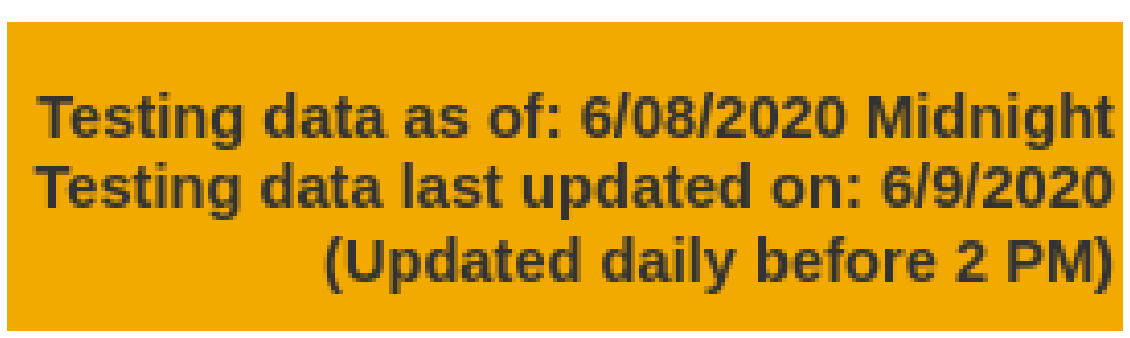

Image pre-processing for Tesseract


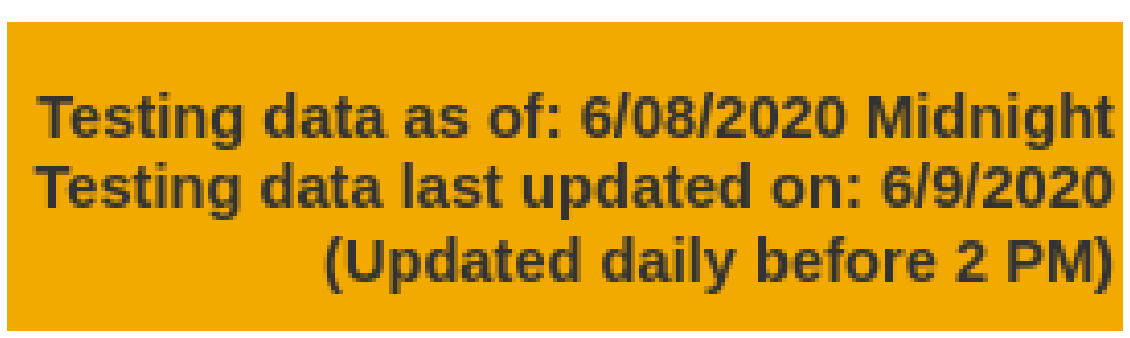

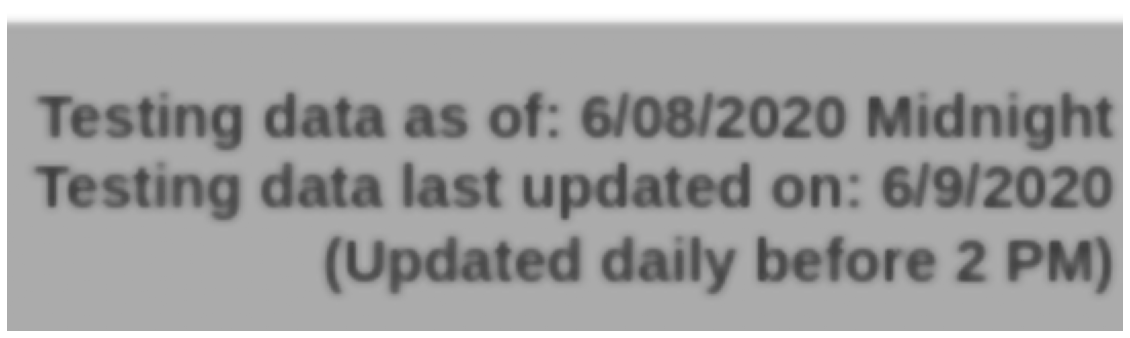

Get raw OCR output from tesseract
Testing data as of: 6/08/2020 Midnight
Testing data last updated on: 6/9/2020
(Updated daily before 2 PM)
Split OCR text output on newlines and remove blank lines.
Get OCR output for total deaths
OCR attempt #1.



Screenshot of New York State-3 dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_ny.png
Crop image


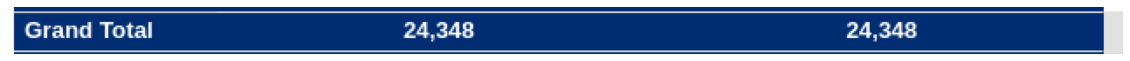

Image pre-processing for Tesseract


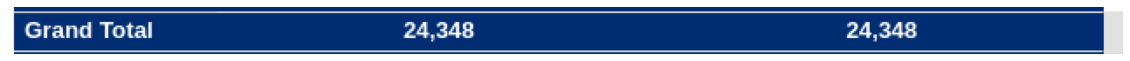

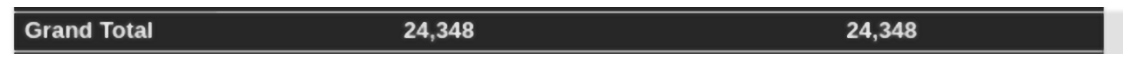

Get raw OCR output from tesseract
| Grand Total PT] yo
Split OCR text output on newlines and remove blank lines.
invalid literal for int() with base 10: 'PT]'
OCR attempt #2.  Trying different preprocessing blur.



Screenshot of New York State-3 dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_ny.png
Crop image


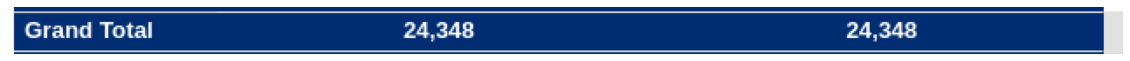

Image pre-processing for Tesseract


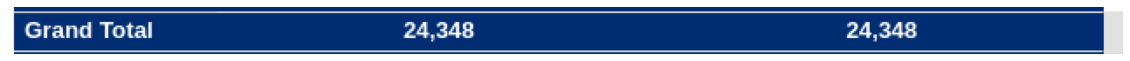

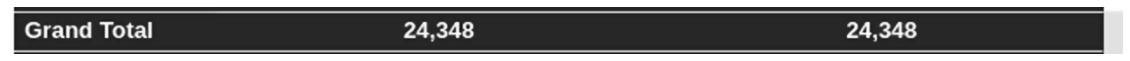

Get raw OCR output from tesseract
| Grand Total 24,348 ye Z8}
Split OCR text output on newlines and remove blank lines.
OCR success on attempt #2!


In [24]:
output['New York State'] = data_extract_nystate(validation=False, home_dir=home_dir)

# Combining into a single dataframe

In [25]:
output_df = pd.DataFrame(output).T
output_df

,Location,Date Published,Total Cases,Total Deaths,Count Cases Black/AA,Count Deaths Black/AA,Pct Cases Black/AA,Pct Deaths Black/AA,Status code
Louisiana,Louisiana,6/8/2020,3612,2844,NaN,NaN,NaN,53.2,Success!
New York State,New York State,6/9/2020,NaN,24348,NaN,NaN,NaN,17,Success!


In [26]:
output_df['Count Deaths Black/AA'] =  np.floor(output_df['Pct Deaths Black/AA'] / 100 * output_df['Total Deaths'])
output_df

,Location,Date Published,Total Cases,Total Deaths,Count Cases Black/AA,Count Deaths Black/AA,Pct Cases Black/AA,Pct Deaths Black/AA,Status code
Louisiana,Louisiana,6/8/2020,3612,2844,NaN,1513,NaN,53.2,Success!
New York State,New York State,6/9/2020,NaN,24348,NaN,4139,NaN,17,Success!


In [32]:
from datetime import datetime
date_stamp = datetime.now().strftime('%Y-%m-%d')

## Export  to CSV
out_file = os.path.join(home_dir, 'output', 'csv', 'covid_disparities_output_OCR_' + date_stamp + '.csv')
output_df.to_csv(out_file)

##  Export to Excel
out_file = os.path.join(home_dir, 'output', 'xlsx', 'covid_disparities_output_OCR_' + date_stamp + '.xlsx')
output_df.to_excel(out_file)

# Stop Docker

In [28]:
stop_docker(client_chrome)
stop_docker(client_firefox)

In [29]:
#!docker ps

In [30]:
client_chrome.containers.list(), client_firefox.containers.list()

([], [])